Dependencies


Load models and show them

In [23]:
import clip
import numpy as np
import torch
from pkg_resources import packaging

print("Torch version:", torch.__version__)

clip.available_models()

Torch version: 2.3.0+cu121


['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

take model

In [24]:
model, preprocess = clip.load("RN50")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 102,007,137
Input resolution: 224
Context length: 77
Vocab size: 49408


In [25]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7d7cd1548b80>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

In [26]:
clip.tokenize("Hello World!")

tensor([[49406,  3306,  1002,   256, 49407,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

setting up input images


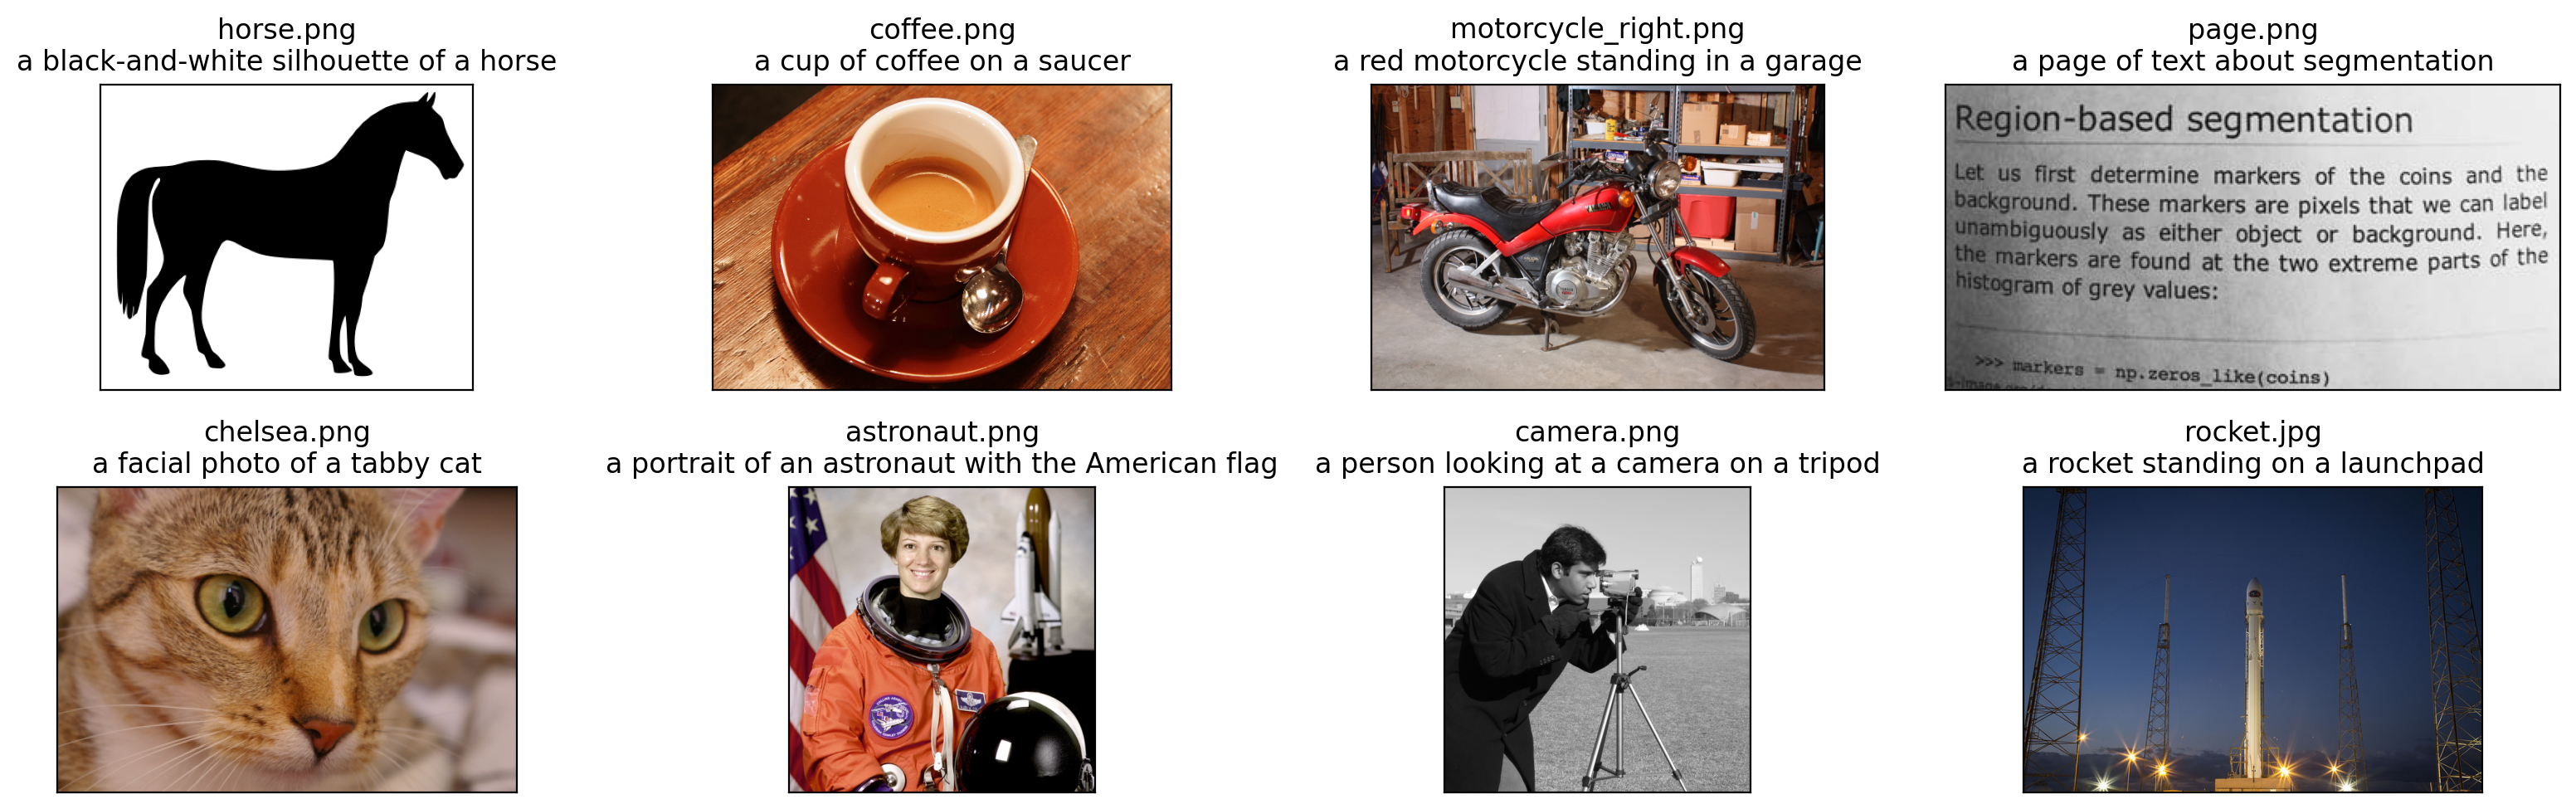

In [27]:
import os
import skimage
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# images in skimage to use and their textual descriptions
descriptions = {
    "page": "a page of text about segmentation",
    "chelsea": "a facial photo of a tabby cat",
    "astronaut": "a portrait of an astronaut with the American flag",
    "rocket": "a rocket standing on a launchpad",
    "motorcycle_right": "a red motorcycle standing in a garage",
    "camera": "a person looking at a camera on a tripod",
    "horse": "a black-and-white silhouette of a horse",
    "coffee": "a cup of coffee on a saucer"
}


original_images = []
images = []
texts = []
plt.figure(figsize=(16, 5))

for filename in [filename for filename in os.listdir(skimage.data_dir) if filename.endswith(".png") or filename.endswith(".jpg")]:
    name = os.path.splitext(filename)[0]
    if name not in descriptions:
        continue

    image = Image.open(os.path.join(skimage.data_dir, filename)).convert("RGB")

    plt.subplot(2, 4, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{filename}\n{descriptions[name]}")
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    images.append(preprocess(image))
    texts.append(descriptions[name])

plt.tight_layout()

Augmentations


In [28]:
from torchvision import transforms

def complex_random_augmentation(image):
    # Lista di trasformazioni potenzialmente applicabili
    transform_list = [
        transforms.RandomHorizontalFlip(p=0.5),  # Flip orizzontale con 50% di probabilità
        transforms.RandomVerticalFlip(p=0.2),    # Flip verticale con 20% di probabilità
        transforms.RandomRotation(45),           # Rotazione casuale di ±45 gradi
        transforms.RandomApply([                 # Applica con probabilità del 30% la seguente trasformazione
            transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1)
        ], p=0.3),
        transforms.RandomResizedCrop(size=(256, 256), scale=(0.5, 1.0), ratio=(0.75, 1.33)),  # Crop ridimensionato casuale
        transforms.RandomGrayscale(p=0.1),       # Conversione in scala di grigi con 10% di probabilità
        transforms.RandomApply([                 # Applica con probabilità del 40% la seguente trasformazione
            transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))
        ], p=0.4)
    ]

    # Componi tutte le trasformazioni
    augmentation = transforms.Compose(transform_list)

    # Applica le trasformazioni all'immagine
    augmented_image = augmentation(image)
    return augmented_image

In [29]:
from torchvision.datasets import CIFAR100


augment_images = [complex_random_augmentation(image) for image in original_images]
_augment_images = [preprocess(image) for image in augment_images]
augment_images_input = torch.tensor(np.stack(_augment_images)).cuda()


text_probs_ = (100.0 * augment_images_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs_.cpu().topk(5, dim=-1)

cifar100 = CIFAR100(os.path.expanduser("~/.cache"), transform=preprocess, download=True)

text_descriptions = [f"This is a photo of a {label}" for label in cifar100.classes]
text_tokens = clip.tokenize(text_descriptions).cuda()

with torch.no_grad():
    augment_images_features = model.encode_image(augment_images_input).float()
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)
    
text_probs = (100.0 * augment_images_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

Files already downloaded and verified


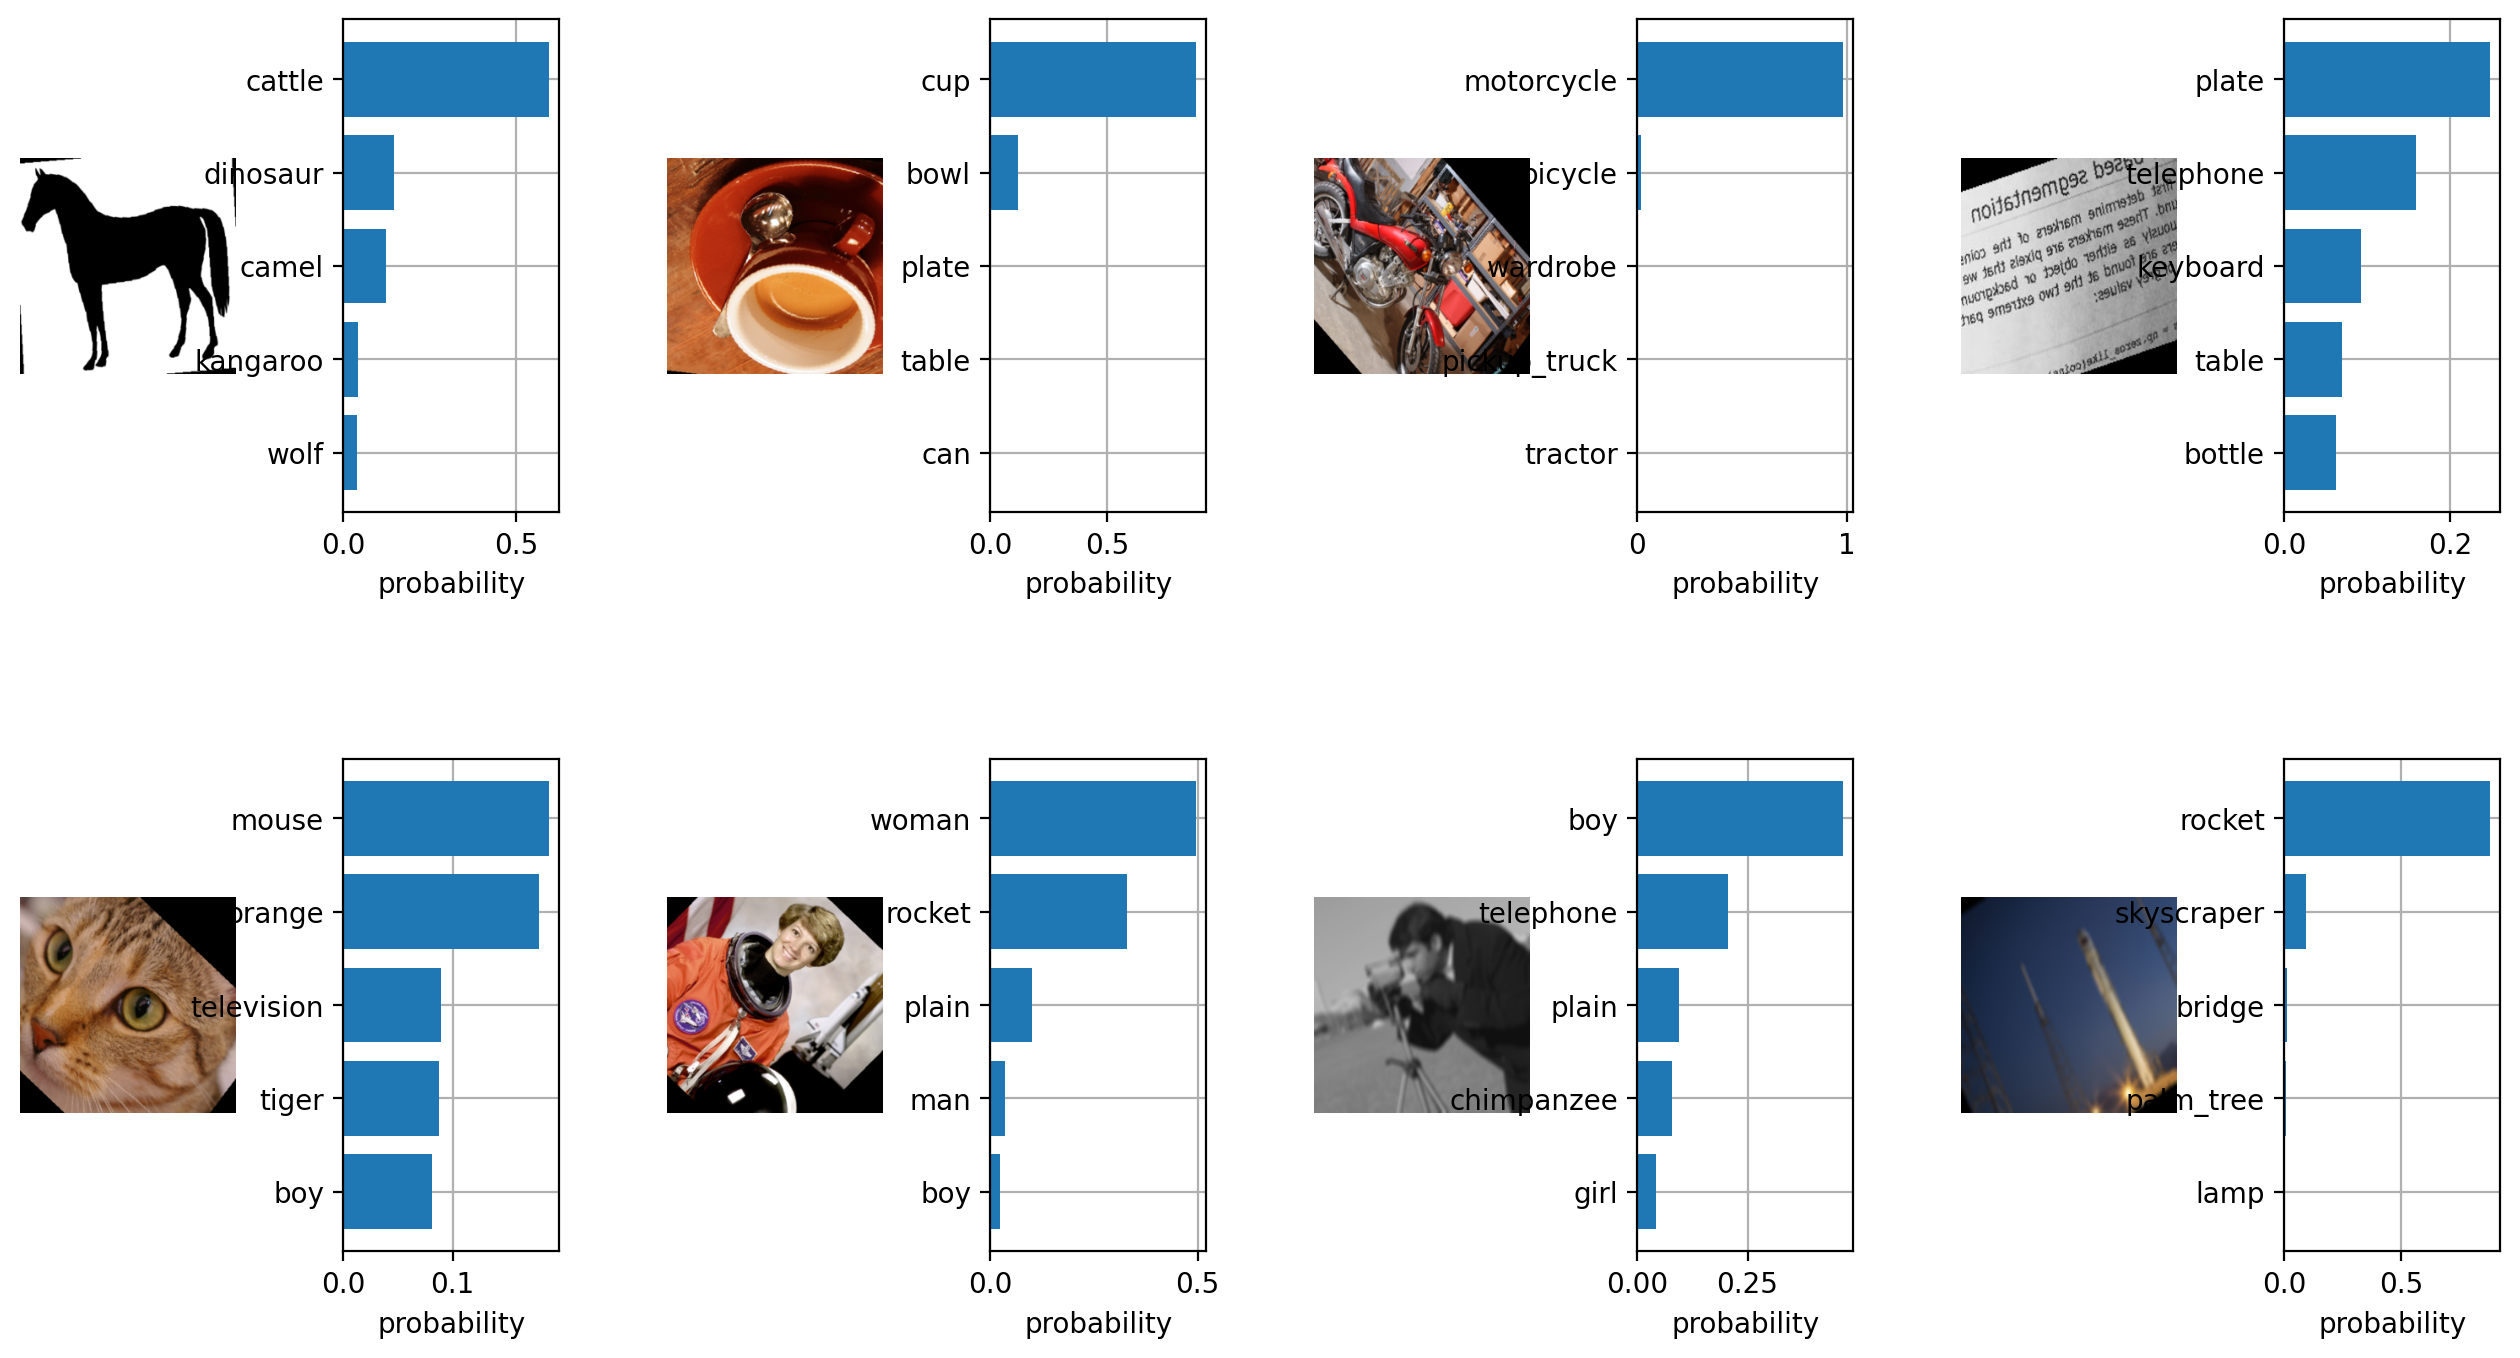

In [30]:
num_images = len(augment_images)
cols = 4  # Definisci il numero di colonne per la griglia di subplot
rows = (num_images + cols - 1) // cols  # Calcola il numero di righe necessarie

plt.figure(figsize=(16, rows * 4))  # Modifica l'altezza in base al numero di righe

for i, image in enumerate(augment_images):
    # Subplot per l'immagine
    plt.subplot(rows, cols * 2, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    # Subplot per il grafico a barre delle probabilità
    plt.subplot(rows, cols * 2, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [cifar100.classes[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5, hspace=0.5)  # Adjust lo spazio tra i subplot
plt.show()